In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import sys
import math

import libst

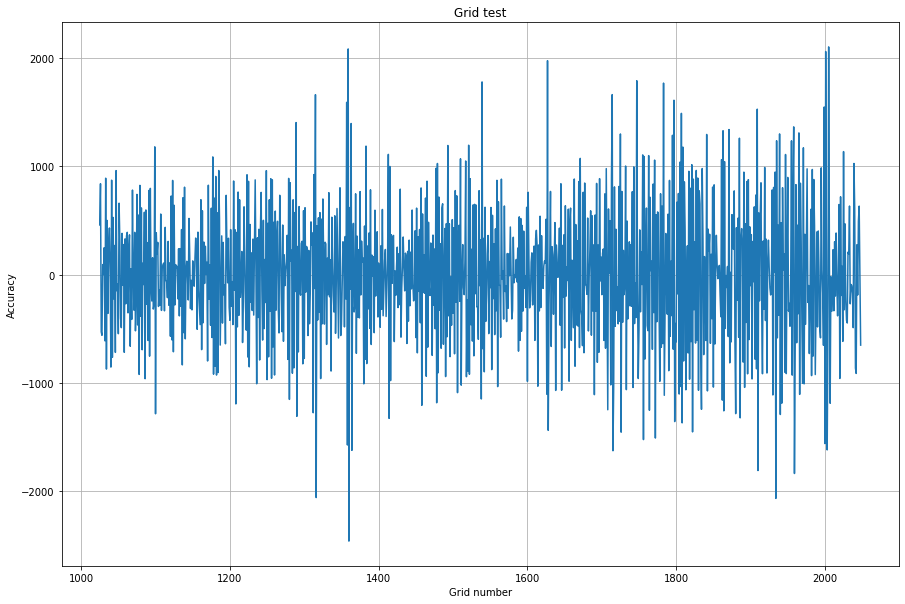

In [6]:
class LinearScalarErrorTC():
    """
    Compare linear solver's solution wtih exact solution, because solutions of computation field is a vector,
    therefore compared the norm of difference bewteen solver's solution and exact solution.

    By comparing norm of difference bewteen solver's solution and exact solution we can check if the linear solver is work properly
    or check if the solver's mathematical model is correct.
    """

    @staticmethod
    def _build_solver(resolution):
        """ Create linear solver object for norm test
            Args:
              resolution:
                Grid number
            Return:
                A well set linear solver object
        """
        grid = libst.Grid(0, 4 * 2 * np.pi, resolution)
        cfl = 1
        dx = (grid.xmax - grid.xmin) / grid.ncelm
        dt = dx * cfl
        svr = libst.LinearScalarSolver(grid=grid, time_increment=dt)

        # Initialize
        for e in svr.selms(odd_plane=False):
            if e.xctr < 2 * np.pi or e.xctr > 4 * np.pi:
                v = 0
                dv = 0
            else:
                v = np.sin(e.xctr)
                dv = np.cos(e.xctr)
            e.set_so0(0, v)
            e.set_so1(0, dv)

        svr.setup_march()

        return svr

    @staticmethod
    def _exact_solution(svr, iter_num, gfun):
        """ Calculate exact solution of the 1D advection equation
            Args:
              svr:
                Linear wave solver
              iter_num:
                How many step will be executed
              gfun:
                System function
             Return:
                A ndarray which content current time step solution
        """
        v = []
        for e in svr.selms(odd_plane=False):
            x = (
                e.xctr - iter_num * svr.dt % svr.grid.xmax
            )  # dealt with boundary treatment
            if x < 2 * np.pi or x > 4 * np.pi:
                v.append(0)
            else:
                v.append(gfun(x))
        return np.array(v)

    @staticmethod
    def _norm(vec, ord=1):
        """ Calculate the vector norm
            Args:
              vec:
                Vector for norm calculation
              ord:
                Norm order
            Return:
                A double number, vector norm
        """
        res = 0
        for ele in vec:
            res += abs(ele) ** ord
        return res ** (1 / ord)
            
# grid_num = [1024, 2048, 4096, 8192]

grid_num = range(1024, 2049)

h_arr = []

err = []

it_num = 10

for grid in grid_num:
    svr = LinearScalarErrorTC._build_solver(grid)
    svr.march_alpha2(it_num)
    h_arr.append((svr.grid.xmax - svr.grid.xmin) / svr.grid.ncelm)
    err.append(LinearScalarErrorTC._norm(
                svr.get_so0(0).ndarray - 
                LinearScalarErrorTC._exact_solution(svr, it_num, np.sin),
                2))

idx = range(1, len(err))
tmp = []
for i in idx:
    tmp.append(math.log(abs(err[i] / err[i - 1])) / math.log(abs(h_arr[i] / h_arr[i - 1])))
#     tmp.append(err[i] / err[i - 1])
    
plt.figure(figsize=(15,10))
plt.xlabel('Grid number')
plt.ylabel('Accuracy')
# plt.yscale('log')
plt.title('Grid test')
plt.grid()
plt.plot(grid_num[1:], tmp, '-')
    
    